# Connecting Papers

In this notebook, we merge the retrieved and cleaned data from the previous steps.

We then create a new column that contains lists of eids that are part of my dataset.


In [1]:
# Standard library imports
import json
import os

# auto reload
%load_ext autoreload
%autoreload 2

# Third party imports
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from dotenv import load_dotenv
from tqdm import tqdm

# Configure matplotlib
%matplotlib inline

# Load environment variables from .env file
load_dotenv()

# Access environment variables
python_path = os.getenv('PYTHONPATH')
data_dir = os.getenv('DATA_DIR')
src_dir = os.getenv('SRC_DIR')
output_dir = os.getenv('OUTPUT_DIR')

# Load the data.

article data and reference data


In [2]:
p_df = data_dir + "/02-clean/articles/scopus_cleaned_20250326_081230.pkl"
df = pd.read_pickle(p_df)
print(df.shape)

p_refs = data_dir + "/02-clean/references/eid_reference_dict_20250328.json"
with open(p_refs, "r") as f:
    eid_reference_dict = json.load(f)

# p_raw_refs    = data_dir + "/02-clean/references/raw_eid_reference_dict_20250328.json"
# with open(p_raw_refs, "r") as f:
#    raw_eid_reference_dict = json.load(f)

print(f" Nr of references: {len(eid_reference_dict)}")

(38961, 28)
 Nr of references: 38961


map the number of references to each article based on the eid


In [3]:
df["reference_eids"] = df["eid"].map(eid_reference_dict)
# df['raw_references'] = df['eid'].map(raw_eid_reference_dict)

# get a nan df
df_nan = df[df["reference_eids"].isna()]

df_nan.shape

(1906, 29)

In [4]:
df["nr_references"] = df["reference_eids"].apply(
    lambda x: len(x) if not isinstance(x, float) else 0
)

# Number of references per paper per year


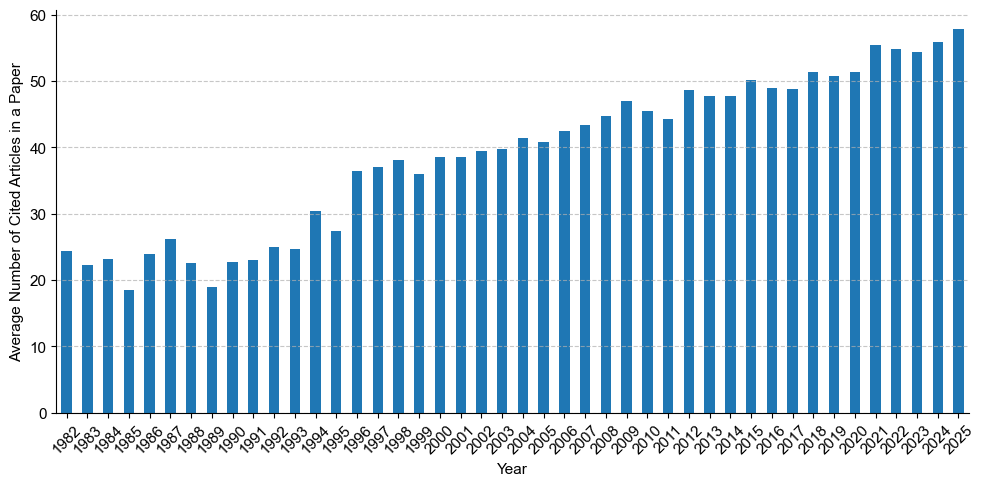

In [5]:
# use aria, font size 11
plt.rcParams.update({"font.size": 11})
plt.rcParams.update({"font.family": "Arial"})


# Group the DataFrame by the "year" column and calculate the mean of "nr_references" for each year
average_references_by_year = df.groupby("year")["nr_references"].mean()

# Plot the average number of references in a year
plt.figure(figsize=(10, 5))
average_references_by_year.plot(
    kind="bar", xlabel="Year", ylabel="Average Number of Cited Articles in a Paper"
)
plt.xticks(rotation=45)
# plt.title("Average Number of References in a Year")
plt.grid(axis="y", linestyle="--", alpha=0.7)
sns.despine(top=True, right=True)
plt.tight_layout()
plt.savefig(
    output_dir + f"/figures/total_average_references_by_year_20250326.png", dpi=300
)
plt.show()

# Insample

## Number of links per paper per year


## connect papers


In [6]:
# Create a set of unique eids for faster membership checking
unique_eids = set(df["eid"].values)


# Function to filter "reference_eids" based on "eid" column
def filter_reference_eids(reference_eids, unique_eids):
    # Check if reference_eids is NaN or None
    if isinstance(reference_eids, float) and np.isnan(reference_eids):
        return []
    if reference_eids is None:
        return []

    # Otherwise, proceed with filtering
    return list(set([eid_ref for eid_ref in reference_eids if eid_ref in unique_eids]))


# Apply the filter function to create a new column
df["filtered_reference_eids"] = df["reference_eids"].apply(
    filter_reference_eids, args=(unique_eids,)
)

# nr of references after filtering
df["nr_filtered_references"] = df["filtered_reference_eids"].map(lambda x: len(x))
print(
    f"Average number of filtered references: {df['nr_filtered_references'].mean():.2f}"
)

Average number of filtered references: 9.12


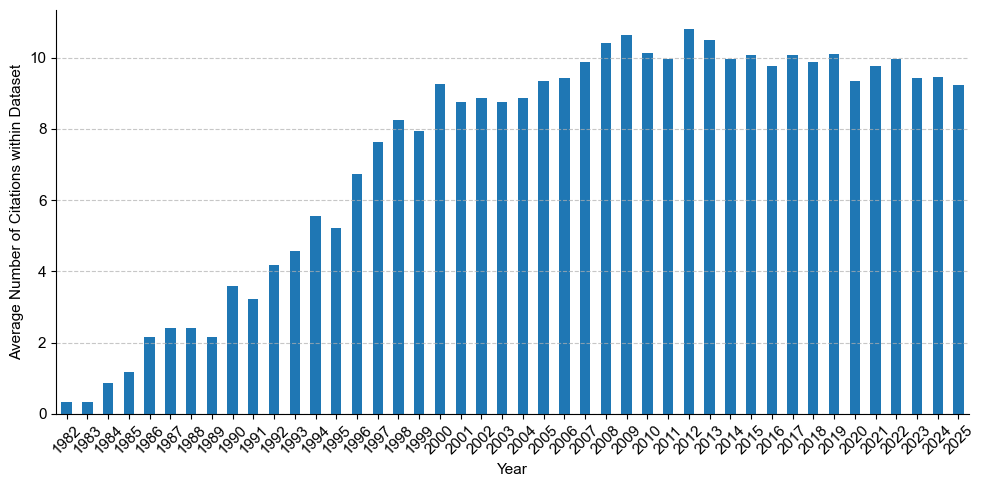

In [7]:
# use aria, font size 11
plt.rcParams.update({"font.size": 11})
plt.rcParams.update({"font.family": "Arial"})
# plot the average number of filtered references in a year
average_filtered_references_by_year = df.groupby("year")[
    "nr_filtered_references"
].mean()
plt.figure(figsize=(10, 5))
average_filtered_references_by_year.plot(
    kind="bar", xlabel="Year", ylabel="Average Number of Citations within Dataset"
)

# rotate xticks
plt.xticks(rotation=45)
# plt.title("Average Number of Filtered References in a Year")
plt.grid(axis="y", linestyle="--", alpha=0.7)
# remove top and right spines
sns.despine(top=True, right=True)
plt.tight_layout()
plt.savefig(
    output_dir + f"/figures/insample_average_references_by_year_20250326.png", dpi=300
)
plt.show()

## create descriptes dataframe


In [8]:
# create dataframe with year and average number of references and average number of filtered references
nr_references_descriptive_df = pd.DataFrame(
    {
        "year": average_references_by_year.index,
        "average_references": average_references_by_year.values,
        "average_insample_references": average_filtered_references_by_year.values,
    }
)

path = output_dir + "/tables/descriptives/nr_references_descriptive_df_20250326.csv"

nr_references_descriptive_df.to_csv(path, index=False)

# Save dataframe


In [9]:
df.to_pickle(data_dir + "/03-connected/scopus_cleaned_connected_20250326.pkl")

In [10]:
df.columns

Index(['eid', 'title', 'date', 'first_author', 'abstract', 'doi', 'year',
       'auth_year', 'unique_auth_year', 'pubmed_id', 'api_url', 'scopus_id',
       'journal', 'citedby_count', 'publication_type', 'publication_subtype',
       'publication_subtype_description', 'author_count', 'authors_json',
       'authkeywords', 'funding_no', 'openaccess', 'openaccess_flag',
       'freetoread', 'freetoread_label', 'fund_acr', 'fund_sponsor',
       'article_number', 'reference_eids', 'nr_references',
       'filtered_reference_eids', 'nr_filtered_references'],
      dtype='object')